<a href="https://colab.research.google.com/github/Chakazul/HANet/blob/master/hanet_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HANet in TensorFlow 2.0

Generative art is one of the most exciting area of deep learning research, producing amazing imagery using DeepDream, Neural Style Transfer, BigGAN, StyleGAN... etc.  For beginners in machine learning (like me), hardmaru's **VAE+CPPN+GAN** model is a good start to understand how neural networks generate artistic images, and to practice deep learning techniques.  Please read the [original blog post](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) for an excellent walkthrough.

Since the name is a bit clumsy, let me call it **HANet** for **Hybrid Architecture Network** (or simply, Ha's Net) while generalizing the approach.

HANet explores the potential of mix-and-matching various components from existing deep learning models.  The approach includes a few general architectures (AE, GAN, AAE), each consists of components (Q, G, D), and each component consists of layers (Conv2D, Dense, etc).  To elaborate,
- AE (autoencoder) = Q (encoder) + G (decoder)
- GAN (generative adversarial network) = G (generator) + D (discriminator)
- AAE (adversarial autoencoder) = Q (encoder) + G (decoder/generator) + D (discriminator)

Possible sources of components:
- Encoder (Q) from VAE, DCIGN
- Decoder/Generator (G) from VAE, DCIGN, DCGAN, CPPN
- Discriminator (D) from DCGAN

For example, hardmaru's version is AAE with encoder from VAE, decoder/generator from CPPN, and discriminator from DCGAN.

Here in this Colab notebook, you can try out different combinations yourself.  First run "Setup", "Data" and "Components" sections to get things prepared, then choose one of the "AE", "GAN" or "AAE" architecture to do experiments.  Inside each architecture, you can pick which components to use, or modify the layers within the components.  Train the model for 30 epochs and see if it can reconstruct the images, and if you're using CPPN, see if it can generate HD versions with amazing quality.

Here we use the brand new **[TensorFlow 2.0 alpha](https://www.tensorflow.org/alpha)** with its reorganized, intuitive API using eager execution, gradient tape, and native Keras support.  Compare to hardmaru's [original implementation](https://github.com/hardmaru/cppn-gan-vae-tensorflow) at the time TensorFlow just got open sourced, painstakingly defining low-level logic and layers, we can see the immense improvements in TensorFlow's usability and expressiveness.  Google Colab provides a shared, easy to use environment, and free GPU!

---

-- [GitHub repo](https://github.com/Chakazul/HANet)

-- twitter @BertChakovsky



# Setup

Download and install TensorFlow 2.0 alpha (not yet Colab's default at the time of writing), install again if version check shows 1.3.0.  Also define a few global constants.  (Todo: use TensorBoard) 

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
# !pip install -q tensorboardcolab


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import IPython.display as display
import google.colab.files as files
import sys, time
import imageio, glob

print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

# import tensorboardcolab as tbc
# tb = tbc.TensorBoardColab()

Python version:  3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
TensorFlow version:  2.0.0-alpha0
GPU found at: /device:GPU:0


In [0]:
''' Define global constants '''

NBATCH = 500  # size of mini-batch
NX = 28  # image width
NY = 28  # image height
NC = 1   # number of channels (1=monochrome)
NZ = 32  # VAE: size of latent variable
SCALE = 6  # CPPN: zooming scale


# Data

Download the training and testing data.  Choose either MNIST (number digits -- run the 1st cell) or [KMNIST](http://codh.rois.ac.jp/kmnist/) (Japanese cursive characters -- run the 2nd cell), then pre-process the dataset.  Also pre-calculate  coordinate matrices for CPPN input.


In [0]:
''' Option 1 -- load MNIST dataset '''

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [0]:
''' Option 2 -- load KMNIST dataset '''

# !wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz
# !wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz
# !wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz
# !wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz

!wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget -c -N -nv http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

PREFIX = 'kmnist'
x_train = np.load(PREFIX+'-train-imgs.npz')['arr_0']
y_train = np.load(PREFIX+'-train-labels.npz')['arr_0']
x_test = np.load(PREFIX+'-test-imgs.npz')['arr_0']
y_test = np.load(PREFIX+'-test-labels.npz')['arr_0']
NCAT = 10


In [0]:
''' Pre-process dataset '''

x_train = x_train.reshape(-1, NY, NX, NC).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, NY, NX, NC).astype(np.float32) / 255.0

NSAMPLE = x_train.shape[0]
x_batches = tf.data.Dataset.from_tensor_slices(x_train).shuffle(NSAMPLE).batch(NBATCH)
print(x_train.shape, x_test.shape)

def find_x(digit):
  ''' find testing data by digit '''
  i = -1
  while i == -1 or y_test[i] != digit:
    i = np.random.randint(y_test.shape[0])
  return x_test[i:i+1]


(60000, 28, 28, 1) (10000, 28, 28, 1)


In [0]:
''' Pre-calculate CPPN coordinate matrices '''

def create_coordinates(nx=NX, ny=NY, scale=SCALE, nbatch=NBATCH):
  n = (nx + ny) / 2
  nx2, ny2 = nx/n*scale, ny/n*scale
  xs, ys = np.meshgrid(np.linspace(-nx2, nx2, nx), np.linspace(-ny2, ny2, ny))
  rs = np.sqrt(xs**2 + ys**2)

  xs_repeat = np.tile(np.reshape(xs, (1, nx*ny, 1)), (nbatch, 1, 1))
  ys_repeat = np.tile(np.reshape(ys, (1, nx*ny, 1)), (nbatch, 1, 1))
  rs_repeat = np.tile(np.reshape(rs, (1, nx*ny, 1)), (nbatch, 1, 1))
  coords = np.concatenate((xs_repeat, ys_repeat, rs_repeat), axis=-1).astype(np.float32)
  return coords, xs, ys, rs

coords, xs, ys, rs = create_coordinates()
# plt.imshow(rs, cmap='jet')
# plt.colorbar()

coords_sample, _, _, _ = create_coordinates(nbatch=5)

print(coords.shape)


(500, 784, 3)


# Components

Define various components and loss functions for mix-and-match.  Feel free to add new ones, modify or rearrange layers, or change layer settings e.g. weight initialization, conv kernel.

In [0]:
''' VAE (variational autoencoder) using MLP (multilayer perceptron) '''

def model_vae_encoder(name='VAE-Q', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NY, NX, NC)),
      layers.Flatten(),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(NZ + NZ),
  ], name=name)
  
def model_vae_decoder(name='VAE-P', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NZ,)),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(nodes, activation='relu'),
      layers.Dense(NX*NY*NC, activation='sigmoid'),
      layers.Reshape([NY, NX, NC,]),
  ], name=name)


''' DCIGN (deep convolutional inverse graphics network) 
    = VAE using CNN (convolutional neural network) '''

def model_dcign_encoder(name='DCIGN-Q', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NY, NX, NC)),
      layers.Conv2D(nodes*1, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2D(nodes*2, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Flatten(),
      layers.Dense(NZ + NZ),
  ], name=name)
  
def model_dcign_decoder(name='DCIGN-P', nodes=32):
  return tf.keras.Sequential([
      layers.InputLayer(input_shape=(NZ,)),
      layers.Dense(7*7*nodes, activation='relu'),
      layers.Reshape((7, 7, nodes)),
      layers.Conv2DTranspose(nodes*2, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2DTranspose(nodes*1, (3,3), strides=(2,2), padding='same', activation='relu'),
      layers.Conv2DTranspose(NC, (3,3), strides=(1,1), padding='same'),
  ], name=name)

def param_split(z_params):
  return tf.split(z_params, 2, axis=1)

def sample_func(z_params, mean=0, stddev=1):
  z_mean, z_logvar = param_split(z_params)
  eps = tf.random.normal(shape=tf.shape(z_mean), mean=mean, stddev=stddev)
  return z_mean + tf.exp(z_logvar * 0.5) * eps

def sample(z_params, mean=0, stddev=1):
  return layers.Lambda(sample_func)(z_params)


''' CPPN (compositional pattern-producing network) '''

def repeat_vector(inputs):
  ''' https://github.com/keras-team/keras/issues/7949 '''
  vec_in, dim_in = inputs
  return layers.RepeatVector(K.shape(dim_in)[1])(vec_in)

def model_cppn_generator(name='CPPN-G', levels=4, nodes=32, stddev=1):
  normal_init = tf.keras.initializers.RandomNormal(stddev=stddev)
  inits = {'kernel_initializer':normal_init, 'bias_initializer':normal_init}

  z_in = layers.Input(shape=(NZ,))
  coord_in = layers.Input(shape=(None, 3))
  h = layers.Lambda(repeat_vector, output_shape=(None, NZ))([z_in, coord_in])
  h = layers.Concatenate()([h, coord_in])
  h = layers.Dense(nodes, activation='softplus', **inits)(h)
  for i in range(levels):
    h = layers.Dense(nodes, activation='tanh', **inits)(h)
  h = layers.Dense(NC, activation='sigmoid', **inits)(h)
  x_out = layers.Flatten()(h)
  return tf.keras.Model(inputs=[z_in, coord_in], outputs=x_out, name=name)

def sq(x, nx=NX, ny=NY, nc=NC):
  return tf.reshape(x, (-1, ny, nx, nc))


''' DCGAN (deep convolutional generative adversarial network) '''
''' from DCGAN paper: bn for all layers (exc G output and D input), relu in G, tanh in G output, lrelu in D '''

def model_dcgan_generator(name='DCGAN-G', filters=32, stddev=0.02):
#   inits = {'kernel_initializer':tf.keras.initializers.RandomNormal(stddev=stddev)}
  inits = {}

  model = tf.keras.Sequential(name=name)
  model.add(layers.InputLayer(input_shape=(NZ,)))
  model.add(layers.Dense(7*7*filters*4, **inits))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((7, 7, filters*4)))
  for f, s in zip([2,1], [1,2]):
    model.add(layers.Conv2DTranspose(filters*f, (5,5), strides=(s,s), padding='same', **inits))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
  model.add(layers.Conv2DTranspose(NC, (5,5), strides=(2,2), padding='same', **inits, activation='tanh'))
  assert model.output_shape == (None, NY, NX, NC)
  return model

def model_dcgan_discriminator(name='DCGAN-D', filters=32, stddev=0.02):
#   inits = {'kernel_initializer':tf.keras.initializers.RandomNormal(stddev=stddev)}
  inits = {}

  model = tf.keras.Sequential(name=name)
  model.add(layers.InputLayer(input_shape=(NY, NX, NC)))
  for f in [1,2]:
    model.add(layers.Conv2D(filters*f, (5,5), strides=(2,2), padding='same', **inits))
    if f>1: model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
  model.add(layers.Flatten())
  model.add(layers.Dense(1, **inits))  # no need activation='sigmoid' if using binary_crossentropy(from_logits=True) -- https://stackoverflow.com/questions/45741878/using-binary-crossentropy-loss-in-keras-tensorflow-backend
  return model


''' Show graph of models '''

def display_models(models):
  imgs = []
  for m in models:
    tf.keras.utils.plot_model(m, to_file=m.name+'.png', show_shapes=True, show_layer_names=True)
    imgs.append(m.name)
    imgs.append(display.Image(retina=True, filename=m.name+'.png'))
  display.display(*imgs)

# display_models([q, g, d])


In [0]:
''' Define loss functions '''

def kld(z_mean, z_logvar):
  ''' Kullback-Leibler divergence for use in VAE '''
  return -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1) / (NX*NY*NC)

def bce(y1, y2):
  ''' Binary cross-entropy for use in AE '''
  y1_flat = tf.reshape(y1, (-1, NX*NY*NC))
  y2_flat = tf.reshape(y2, (-1, NX*NY*NC))
  return tf.keras.losses.binary_crossentropy(y1_flat, y2_flat)
#   return -K.sum(y1_flat * K.log(1e-10 + y2_flat) + (1-y1_flat) * K.log(1e-10 + 1 - y2_flat), axis=1) / (NX*NY*NC)

def bce_logits(b, y):
  ''' Binary cross-entropy from logits for use in GAN '''
  truth = tf.ones_like(y) if b else tf.zeros_like(y)
  return tf.keras.losses.binary_crossentropy(truth, y, from_logits=True)

# BCE = tf.keras.losses.BinaryCrossentropy()
# BCE_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# Test

Misc utils for testing the model

In [0]:
len(all_q_loss)/NSAMPLE*NBATCH

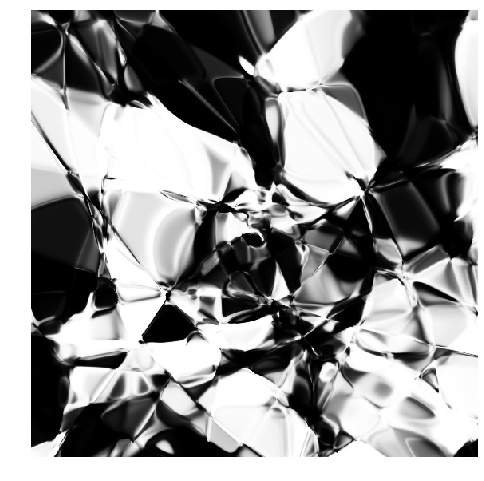

In [0]:
''' test CPPN '''
g = model_cppn_generator(levels=4, nodes=64, stddev=1)

XL = 20
coords_test = create_coordinates(nx=NX*XL, ny=NY*XL, scale=6, nbatch=1)

noise_z = tf.random.normal((1, NZ), stddev=1)
x3 = sq(g([noise_z, coords_test]), nx=NX*XL, ny=NY*XL)

plt.figure(figsize=(8,12))
plt.imshow(tf.reshape(x3[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
plt.axis('off')
plt.show()

In [0]:
''' test tensor shapes '''
q = model_vae_encoder()
g = model_vae_decoder()
# g = model_cppn_generator()
d = model_dcgan_discriminator()

bce = tf.keras.losses.BinaryCrossentropy()
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)


x_batch = x_train[0:10]  # M,X,Y,C
z_mean, z_logvar = params(q(x_batch))
z = sample(z_mean, z_logvar)  # M,Z
x_gen = g(z)  # M,X,Y,C
d_gen = d(x_gen)  # M,1
d_batch = d(x_gen)  # M,1
print(x_batch.shape, z.shape, x_gen.shape, d_gen.shape)

x_batch_flat = tf.reshape(x_batch, (-1, NX*NY*NC))  # M,XYC
x_gen_flat = tf.reshape(x_gen, (-1, NX*NY*NC))  # M,XYC
print(x_batch_flat.shape, x_gen_flat.shape)

bce = tf.keras.losses.binary_crossentropy
bce_logits = lambda y, d: tf.keras.losses.binary_crossentropy(y, tf.zeros_like(y) if d==0 else tf.ones_like(y), from_logits=True)
def kld(z_mean, z_logvar):
  return -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=-1) / (NX*NY*NC)

q_loss_re = bce(x_batch_flat, x_gen_flat) * (NX*NY*NC)  # M,1
q_loss_kl = kld(z_mean, z_logvar)  # 1
q_loss = K.mean(q_loss_re + q_loss_kl) / 2 / (NX*NY*NC)
g_loss = K.mean(bce_logits(d_gen, 1))  # 1
d_loss = K.mean(bce_logits(d_batch, 1) + bce_logits(d_gen, 0)) / 2  # 1
print(q_loss_re.shape, q_loss_kl.shape, q_loss.shape, g_loss.shape, d_loss.shape)

def loss_vae(y_true, y_pred):
  y_true2 = tf.reshape(y_true, [-1, NY*NX*NC])
  y_pred2 = tf.reshape(y_pred, [-1, NY*NX*NC])
  loss_re = tf.keras.losses.binary_crossentropy(y_true2, y_pred2) * (NX*NY*NC)  # M,1
  loss_re2 = -K.sum(y_true2 * K.log(1e-10 + y_pred2) + (1-y_true2) * K.log(1e-10 + 1 - y_pred2), 1)  # M,1
  loss_kl = -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=-1)  # M,1
  loss = K.mean(loss_re + loss_kl) / (NX*NY*NC)  # 1
  print(loss_re.shape, loss_re2.shape, loss_kl.shape, loss.shape)

loss_vae(x_batch, x_gen)


In [0]:
''' test model '''
q = model_vae_encoder()
# g = model_vae_decoder()
g = model_cppn_generator(levels=4, nodes=32, stddev=0.5)
d = model_dcgan_discriminator()
CPPN = True

x = tf.keras.Input(shape=(NX, NY, NC))
z = sample(q(x))
if CPPN:
  x_gen = sq(g([z, coords]))
else:
  x_gen = g(z)
d_gen = d(x_gen)
d_batch = d(x)

m = tf.keras.Model(inputs=x, outputs=[d_gen, d_batch])

display_models([m, q, g, d])

In [0]:
# noise_z = tf.random.normal((5, NZ))
# x2 = sq(g([noise_z, coords_sample])) if CPPN else g(noise_z)
# f, (f1, f2) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 3]})
# f1.imshow(tf.reshape(x2[0], (NY, NX)), vmin=0, vmax=1, cmap='gray', aspect=1)
# f1.axis('off')
# f2.plot(all_g_loss, 'g-', all_d_loss, 'r-')
# f2.axhline(y=0.69, color='c')
# f2.set_ylim(bottom=0)
# f.show()


# AE Training

Define the AE (autoencoder) architecture with an encoder (Q) and a decoder (G).  Q crunches the input image into a latent vector distribution, then G tries to reconstruct the image from a latent vector (sampled from the distribution).

Choose the components by commenting out the other options.  If CPPN is used, feel free to change the number of hidden levels, nodes per level, and initial roughness (stddev of random init).

Train a few epochs at a time and check the quality of image reconstruction and HD generation (if CPPN is used).

In [0]:
''' Define AE architecture '''

# q = model_vae_encoder()
q = model_dcign_encoder()
# g = model_vae_decoder(); CPPN = False
# g = model_dcign_decoder(); CPPN = False
g = model_cppn_generator(levels=4, nodes=128, stddev=1.5); CPPN = True

q_optimizer = tf.keras.optimizers.Adam(1e-3)
q_vars = q.trainable_variables
g_vars = g.trainable_variables

all_q_loss = []

@tf.function
def train_batch_vae(x_batch):
  with tf.device('/gpu:0'):
    with tf.GradientTape() as tape:
      z_params = q(x_batch, training=True)
      z_mean, z_logvar = param_split(z_params)
      z = sample(z_params)
      if CPPN:
        x_gen = sq(g([z, coords], training=True))
      else:
        x_gen = g(z, training=True)

      q_loss = K.mean(bce(x_batch, x_gen) + kld(z_mean, z_logvar))

    q_grads = tape.gradient(q_loss, q_vars + g_vars)
    q_optimizer.apply_gradients(zip(q_grads, q_vars + g_vars))
  return q_loss
  

VAE: DCIGN-Q + CPPN-G


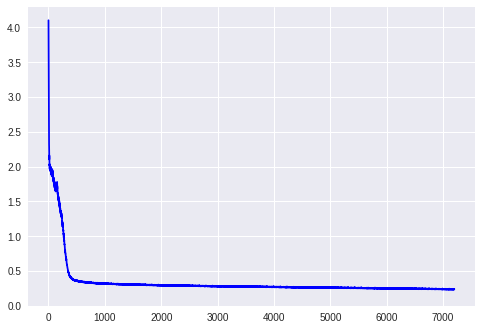

In [0]:
''' Train AE architecture '''

NEPOCH = 10

try:
  print('VAE:', q.name, '+', g.name)
  for epoch in range(NEPOCH):
    start = time.time()
    for batch_no, x_batch in enumerate(x_batches):
      q_loss = train_batch_vae(x_batch)
      all_q_loss.append(q_loss.numpy())
      if batch_no%2==0: print('.', end='')
    print(' {} {:.1f}s loss:{:.4f}'.format(epoch+1, time.time()-start, q_loss.numpy()))
except KeyboardInterrupt:
  pass

plt.plot(all_q_loss, 'b-')
plt.ylim(bottom=0)
plt.show()


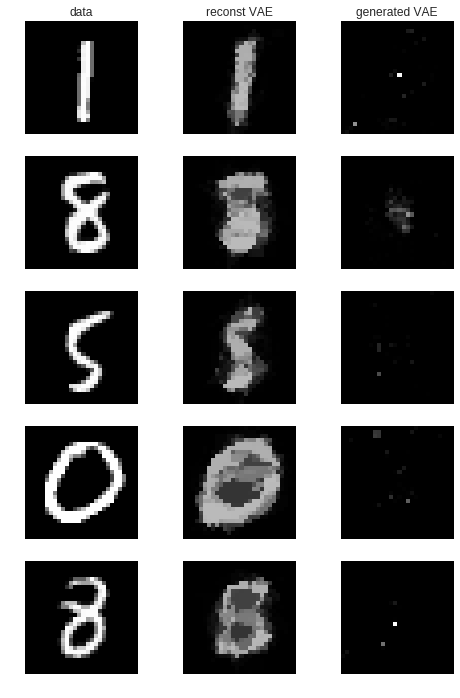

In [0]:
''' Test image reconstruction '''

COLS = 3
ROWS = 5
POS = 180  # test data position

x1 = x_test[POS:ROWS+POS]
z = sample(q(x1), stddev=1)
x2 = sq(g([z, coords_sample])) if CPPN else g(z)
noise_z = tf.random.normal((ROWS, NZ), stddev=1)
x3 = sq(g([noise_z, coords_sample])) if CPPN else g(noise_z)

plt.figure(figsize=(8,12))
for r in range(ROWS):
  for c, xn, c_name, cmap in zip([1,2,3], [x1,x2,x3], ['data','reconst AE','generated AE'], ['gray','gray','gray']):
    plt.subplot(ROWS, COLS, COLS*r+c)
    if r==0: plt.title(c_name)
    plt.imshow(tf.reshape(xn[r], (NY, NX)), vmin=0, vmax=1, cmap=cmap)
    plt.axis('off')
plt.show()


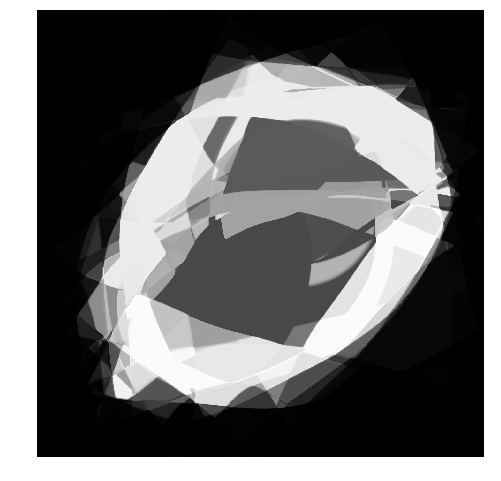

In [0]:
''' Test CPPN HD image generation '''

XL = 50  # enlarge factor
POS = 183  # test data position
coords_XL, _, _, _ = create_coordinates(nx=NX*XL, ny=NY*XL, nbatch=1)

if CPPN:
  x = x_test[POS:POS+1]
  z = sample(q(x))
  x2 = sq(g([z, coords_XL]), nx=NX*XL, ny=NY*XL)
  # noise_z = tf.random.normal((1, NZ))
  # x3 = sq(g([noise_z, coords_XL]), nx=NX*XL, ny=NY*XL)

  plt.figure(figsize=(8,12))
  plt.imshow(tf.reshape(x2[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
  plt.axis('off')
  plt.show()

# GAN Training

Define the GAN (generative adversarial network) architecture with a generator (G) and a discriminator (D).  G tries to generate realistic image to fool D as if it's real, while D tries to recognize dataset images as real and G-generated ones as fake.

Choose the components by commenting out the other options.  If CPPN is used, feel free to change its parameters.

You can adjust the Adam optimizer learning rates and the training loop parameters (e.g. g_loop, d_always).  Train a few epochs at a time and check the quality of image generation and HD generation (if CPPN is used).  Try to keep a balance between G loss and D loss around 0.69.

Unfortunately, I'm not able to reproduce the [beautiful "0"](http://blog.otoro.net/assets/20160401/jpeg/cppgan_0.jpeg) in hardmaru's post.  Please leave me a tweet if you can find the recipe!

In [0]:
''' Define GAN architecture '''

# g = model_dcgan_generator(stddev=0.02); CPPN = False
g = model_cppn_generator(levels=3, nodes=64, stddev=1); CPPN = True
d = model_dcgan_discriminator(stddev=0.02)

g_optimizer = tf.keras.optimizers.Adam(5e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)
g_vars = g.trainable_variables
d_vars = d.trainable_variables

all_g_loss = []
all_d_loss = []

@tf.function
def train_batch_gan(x_batch, g_loop=1, d_always=True, th_high=0.75, th_low=0.6):
  ''' g_loop = number of training on G per once on D
      d_always = always train D or decide with thresholds (th_high, th_low)?
      from hardmaru blog: g_loop=4..8, th_high=0.8, th_low=0.45; github: th_high=0.75, th_low=0.6 '''
  with tf.device('/gpu:0'):
    d_updated = False
    for i in range(g_loop):
      noise_z = tf.random.normal((NBATCH, NZ))
      with tf.GradientTape(persistent=True) as gd_tape:
        if CPPN:
          x_gen = sq(g([noise_z, coords], training=True))
        else:
          x_gen = g(noise_z, training=True)
        d_gen = d(x_gen, training=True)
        d_batch = d(x_batch, training=True)

        g_loss = K.mean(bce_logits(True, d_gen))
        d_loss = K.mean(bce_logits(True, d_batch))/2 + K.mean(bce_logits(False, d_gen))/2

      g_grads = gd_tape.gradient(g_loss, g_vars)
      g_optimizer.apply_gradients(zip(g_grads, g_vars))

      if i == g_loop-1:
        if tf.logical_or(d_always, tf.logical_and(g_loss < th_high, d_loss > th_low)):
          d_grads = gd_tape.gradient(d_loss, d_vars)
          d_optimizer.apply_gradients(zip(d_grads, d_vars))
          d_updated = True

      del gd_tape

  return g_loss, d_loss, d_updated


GAN: CPPN-G + DCGAN-D
oooo.ooooooooooooo...o.....ooooooooooooo.o.ooooooooooooooooo 1 94.3s loss g:0.5896 d:0.9167
ooooooooo....ooooooooooooooooooooooooooooooooooooooooooooooo 2 94.7s loss g:0.6042 d:0.8766
ooooooooooooooooo.oooooooooooooo..o.oo.o.....o.....ooooooooo 3 94.3s loss g:0.4737 d:1.1857
ooo..ooooooooooooooooooooooooooooooooooooooooooooooooooo.ooo 4 94.5s loss g:0.7592 d:0.7248
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo 5 94.1s loss g:0.5058 d:1.0522
oooooooooooooooooooooooooo...ooooooo...ooooooooo.o..oooooooo 6 94.3s loss g:0.6874 d:0.7017
oo.oooooooooooo..oooooooooo.o.ooooooooooooooooo.....oooooooo 7 94.7s loss g:0.6290 d:0.8012
ooo.oooooooooooooooooooooooooo.o...ooooooooo.ooooooooooooooo 8 94.3s loss g:0.7438 d:0.7979
.oooooooooo..ooooooooooo....o..oooooooooooooooooooo.oooooooo 9 94.0s loss g:0.3177 d:1.1316
oooooooooooooooooooooooooooooooooooooooooooooo..oooooooooooo 10 94.3s loss g:0.5764 d:0.8027
ooo.ooooooooooooooooooooooooooooooooooooooooooooooooooooo

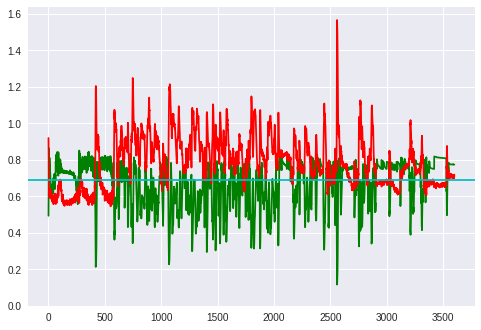

In [0]:
''' Train GAN architecture '''

NEPOCH = 10

try:
  print('GAN:', g.name, '+', d.name)
  for epoch in range(NEPOCH):
    start = time.time()
    for batch_no, x_batch in enumerate(x_batches):
      g_loss, d_loss, d_updated = train_batch_gan(x_batch, g_loop=10, d_always=False) #, th_high=0.8, th_low=0.45)
      all_g_loss.append(g_loss.numpy())
      all_d_loss.append(d_loss.numpy())
      if batch_no%2==0: print('o' if d_updated else '.', end='')
    print(' {} {:.1f}s loss g:{:.4f} d:{:.4f}'.format(epoch+1, time.time()-start, g_loss.numpy(), d_loss.numpy()))
except KeyboardInterrupt:
  pass

plt.plot(all_g_loss, 'g-', all_d_loss, 'r-')
plt.axhline(y=0.69, color='c')
plt.ylim(bottom=0)
plt.show()


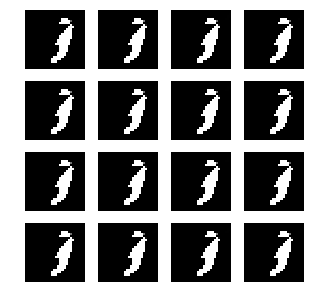

In [0]:
''' Test image generation '''

def show_samples(rows=4, cols=4):
  coords_test = create_coordinates(nbatch=rows*cols)
  noise_z = tf.random.normal((rows*cols, NZ), stddev=1)
  x2 = g([noise_z, coords_test]) if CPPN else g(noise_z)
  fig = plt.figure(figsize=(5,5))
  for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(tf.reshape(x2[i], (NY, NX)), vmin=0, vmax=1, cmap='gray', aspect=1)
    plt.axis('off')
  plt.show()

show_samples(4, 4)

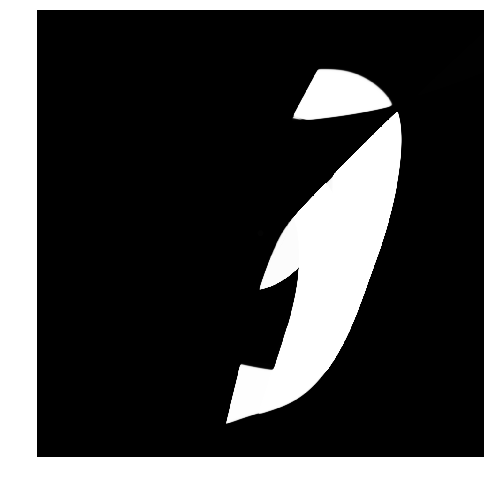

In [0]:
''' Test CPPN HD image generation '''

XL = 50  # enlarge factor
coords_XL, _, _, _ = create_coordinates(nx=NX*XL, ny=NY*XL, nbatch=1)

if CPPN:
  noise_z = tf.random.normal((1, NZ), stddev=1)
  x2 = sq(g([noise_z, coords_XL]), nx=NX*XL, ny=NY*XL)
  # noise_z = tf.random.normal((1, NZ))
  # x3 = sq(g([noise_z, coords_XL]), nx=NX*XL, ny=NY*XL)

  plt.figure(figsize=(8,12))
  plt.imshow(tf.reshape(x2[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
  plt.axis('off')
  plt.show()


# AAE Training

Define the AAE (adversarial autoencoder) architecture -- a combination of AE and GAN -- with an encoder (Q), a decoder/generator (G) and a discriminator (D).  Q crunches the input image into a latent vector distribution, G tries to reconstruct the image from a sampled latent vector and fool D as if it's real, while D tries to recognize dataset images as real and G-generated ones as fake.

Choose the components by commenting out the other options.  If CPPN is used, feel free to change its parameters.

You can adjust the Adam optimizer learning rates and the training loop parameters (e.g. g_loop, d_always).  Train a few epochs at a time and check the quality of image reconstruction and HD generation (if CPPN is used).  Try to keep a balance between G loss and D loss around 0.69, and Q loss as low as possible.


In [0]:
''' Define AAE architecture '''

q = model_vae_encoder()
# g = model_vae_decoder(); CPPN = False
g = model_cppn_generator(levels=3, nodes=64, stddev=1); CPPN = True
d = model_dcgan_discriminator()

q_optimizer = tf.keras.optimizers.Adam(1e-3)
g_optimizer = tf.keras.optimizers.Adam(1e-3)
d_optimizer = tf.keras.optimizers.Adam(1e-4)
q_vars = q.trainable_variables
g_vars = g.trainable_variables
d_vars = d.trainable_variables

all_q_loss = []
all_g_loss = []
all_d_loss = []

@tf.function
def train_batch_aae(x_batch, q_loop=1, g_loop=1, 
                    g_always=True, d_always=True, th_high=0.75, th_low=0.6):
  ''' q_loop, g_loop = number of training on Q/G per once on D
      g_always, d_always = always train G/D or decide with thresholds (th_high, th_low)? '''
  with tf.device('/gpu:0'):
    g_updated = d_updated = False
    for i in range(q_loop):
      with tf.GradientTape() as vae_tape:
        z_params = q(x_batch, training=True)
        z_mean, z_logvar = param_split(z_params)
        z = sample(z_params)
        if CPPN:
          x_gen = sq(g([z, coords], training=True))
        else:
          x_gen = g(z, training=True)

        q_loss = K.mean(bce(x_batch, x_gen) + kld(z_mean, z_logvar))

      q_grads = vae_tape.gradient(q_loss, q_vars + g_vars)
      q_optimizer.apply_gradients(zip(q_grads, q_vars + g_vars))

    for i in range(g_loop):
      with tf.GradientTape(persistent=True) as gan_tape:
        z_params = q(x_batch, training=True)
        z = sample(z_params)
        if CPPN:
          x_gen = sq(g([z, coords], training=True))
        else:
          x_gen = g(z, training=True)
        d_gen = d(x_gen, training=True)
        d_batch = d(x_batch, training=True)

        g_loss = K.mean(bce_logits(True, d_gen))
        d_loss = K.mean(bce_logits(True, d_batch))/2 + K.mean(bce_logits(False, d_gen))/2

      if tf.logical_or(g_always, g_loss > th_low):
        g_grads = gan_tape.gradient(g_loss, q_vars + g_vars)
        g_optimizer.apply_gradients(zip(g_grads, q_vars + g_vars))
        g_updated = True

      if i == g_loop-1:
        if tf.logical_or(d_always, tf.logical_and(g_loss < th_high, d_loss > th_low)):
          d_grads = gan_tape.gradient(d_loss, d_vars)
          d_optimizer.apply_gradients(zip(d_grads, d_vars))
          d_updated = True

      del gan_tape  # explicit delete tape if persistent=True

  return q_loss, g_loss, d_loss, g_updated, d_updated


VAE+GAN: VAE-Q + CPPN-G + DCGAN-D
ooooooooooOoooooooooOooooooooooooooooooo 1 430.9s loss q:0.4645 g:0.7799 d:0.6891
oooooooooooooooooooooooooooooooooooooooo 2 433.0s loss q:0.4591 g:0.7675 d:0.6974
ooOooooooooooooooooooooooooooooooooooooo 3 433.0s loss q:0.4637 g:0.8901 d:0.6506


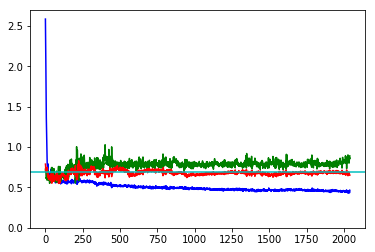

In [0]:
''' Train AAE architecture '''

NEPOCH = 10

try:
  print('VAE+GAN:', q.name, '+', g.name, '+', d.name)
  for epoch in range(NEPOCH):
    start = time.time()
    for batch_no, x_batch in enumerate(x_batches):
      q_loss, g_loss, d_loss, g_updated, d_updated = \
        train_batch_aae(x_batch, q_loop=10, g_loop=10, g_always=False, d_always=False)
      all_q_loss.append(q_loss.numpy())
      all_g_loss.append(g_loss.numpy())
      all_d_loss.append(d_loss.numpy())
      if batch_no%3==0: print('O' if (d_updated and g_updated) else 'o' if (g_updated or d_updated) else '.', end='')
    print(' {} {:.1f}s loss q:{:.4f} g:{:.4f} d:{:.4f}'.format(
        epoch+1, time.time()-start, q_loss.numpy(), g_loss.numpy(), d_loss.numpy() ))
except KeyboardInterrupt:
  pass

plt.plot(all_q_loss, 'b-', all_g_loss, 'g-', all_d_loss, 'r-')
plt.axhline(y=0.69, color='c')
plt.ylim(bottom=0)
plt.show()


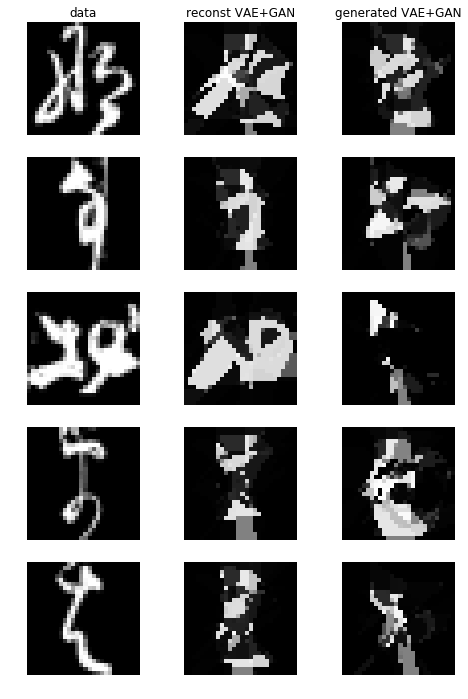

In [0]:
''' Test image reconstruction '''

COLS = 3
ROWS = 5
POS = 180  # test data position

x1 = x_test[POS:ROWS+POS]
z = sample(q(x1), stddev=1)
x2 = sq(g([z, coords_sample])) if CPPN else g(z)
noise_z = tf.random.normal((ROWS, NZ), stddev=1)
x3 = sq(g([noise_z, coords_sample])) if CPPN else g(noise_z)

plt.figure(figsize=(8,12))
for r in range(ROWS):
  for c, xn, c_name, cmap in zip([1,2,3], [x1,x2,x3], ['data','reconst VAE+GAN','generated VAE+GAN'], ['gray','gray','gray']):
    plt.subplot(ROWS, COLS, COLS*r+c)
    if r==0: plt.title(c_name)
    plt.imshow(tf.reshape(xn[r], (NY, NX)), vmin=0, vmax=1, cmap=cmap)
    plt.axis('off')
plt.show()


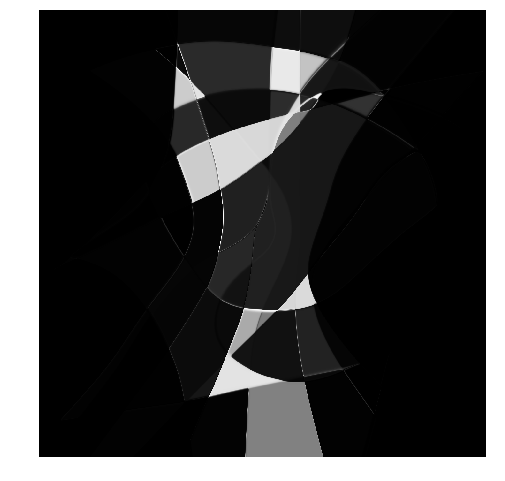

In [0]:
''' Test CPPN HD image generation '''

XL = 50  # enlarge factor
POS = 183  # test data position
choice = 1 # 1=reconstruct, 2=random latent, 3=colored
x = x_test[POS:POS+1]
# x = find_x(0)
coords_XL, _, _, _ = create_coordinates(nx=NX*XL, ny=NY*XL, nbatch=1)

if choice in [1]:
  z = sample_func(q(x), stddev=1)
  x2 = sq(g([z, coords_XL]), nx=NX*XL, ny=NY*XL)
elif choice in [2]:
  noise_z = tf.random.normal((1, NZ), stddev=1.5)
  x2 = sq(g([noise_z, coords_XL]), nx=NX*XL, ny=NY*XL)
elif choice in [3]:
  x2 = np.zeros((NY*XL, NX*XL, 3))
  for i in [0,1,2]:
    z = sample_func(q(x), stddev=1.2)
    x2c = sq(g([z, coords_XL]), nx=NX*XL, ny=NY*XL).numpy()
    x2[:,:,i] = x2c[0,:,:,0]

plt.figure(figsize=(8,12))
if choice in [1,2]:
  plt.imshow(tf.reshape(x2[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
elif choice in [3]:
  plt.imshow(x2, vmin=0, vmax=1)
plt.axis('off')
plt.show()


# GIF

Generate animated GIF by intrapolating latent variables from digit 0 to 9 (or equivalent characters in KMNIST)

In [0]:
# Create and clean temporary folder for individual frames
!mkdir -p image
!rm -f image/*
  
XL = 50  # enlarge factor
n = 5  # frames per digit
coords_XL, _, _, _ = create_coordinates(nx=NX*XL, ny=NY*XL, nbatch=1)

z_0 = z_2 = sample_func(q(find_x(0)), stddev=1)
image_i = 0
for digit in range(1, 11):
  z_1 = z_2
  if digit == 10:  # return to digit 0
    z_2 = z_0
  else:
    z_2 = sample_func(q(find_x(digit)), stddev=1)
  print('{} > {}'.format(digit-1, digit % 10))
  if choice in [1]:
    for k in range(n):
      z = z_1*(n-k)/n + z_2*k/n  # intrapolate
      x2 = sq(g([z, coords_XL]), nx=NX*XL, ny=NY*XL)
      plt.figure(figsize=(8,12))
      plt.imshow(tf.reshape(x2[0], (NY*XL, NX*XL)), vmin=0, vmax=1, cmap='gray')
      plt.axis('off')
      plt.savefig('image/image{:02d}.png'.format(image_i))
      plt.close()
      image_i += 1

anim_file = 'anim.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  for f in sorted(glob.glob('image/image*.png')):
    writer.append_data(imageio.imread(f))
files.download(anim_file)

0 > 1
1 > 2
2 > 3
3 > 4
4 > 5
5 > 6
6 > 7
7 > 8
8 > 9
9 > 0


# Save / Load

Save or load model weights and loss history

In [0]:
# q.save_weights('q.h5'); files.download('q.h5')
# g.save_weights('g.h5'); files.download('g.h5')
# d.save_weights('d.h5'); files.download('d.h5')

# np.savetxt('q.csv', np.asarray(all_q_loss), delimiter=","); files.download('q.csv')
# np.savetxt('g.csv', np.asarray(all_g_loss), delimiter=","); files.download('g.csv')
# np.savetxt('d.csv', np.asarray(all_d_loss), delimiter=","); files.download('d.csv')


In [0]:
# uploaded = files.upload()
# q.load_weights('q.h5')
# g.load_weights('g.h5')
# d.load_weights('d.h5')

# all_q_loss = np.genfromtxt('q.csv', delimiter=",").tolist()
# all_g_loss = np.genfromtxt('g.csv', delimiter=",").tolist()
# all_d_loss = np.genfromtxt('d.csv', delimiter=",").tolist()
